# PaySim 금융 사기 탐지  

## 📓 01. 데이터 기초 분석 (Data_Profiling)



본 데이터셋은 모바일 금융 서비스에서 발생하는 거래를 시뮬레이션한 데이터로,디지털 금융 환경에서 증가하고 있는 사기 거래 위험을 분석할 수 있는 드문 공개 데이터 중 하나이다.

이 데이터의 가장 큰 분석적 난점은 약 600만 건의 거래 중 사기 거래(`isFraud = 1`)가 극히 일부에 불과한 **심각한 클래스 불균형**에 있다.
또한 데이터 설명과 실제 데이터 구조 사이에 일부 불일치가 존재하여, 각 변수의 의미와 신뢰성에 대한 검토가 필요하다.


본 노트북에서는 PaySim 금융 거래 데이터를 대상으로 기초적인 데이터 구조, 분포, 결측치 여부를 확인한다.


- 데이터 구조 이해
- 결측치 / 이상값 존재 여부
- 클래스 불균형 확인
=> 이 데이터 믿을 만한가? 판단!



## Dataset Description


본 프로젝트에서 사용하는 PaySim 데이터는 모바일 금융 거래를 시뮬레이션한 합성 데이터이다.
각 row는 하나의 거래를 의미하며, `step`은 시간 단위(1 step = 1 hour)를 나타낸다.



### 주요 변수 설명

- **step**: 시뮬레이션 시간 (1 step = 1 hour)
- **type**: 거래 유형 (CASH_IN, CASH_OUT, DEBIT, PAYMENT, TRANSFER)
- **amount**: 거래 금액
- **nameOrig**: 거래를 시작한 계좌 ID
- **oldBalanceOrig / newBalanceOrig**: 거래 전·후 송신자 잔액
- **nameDest**: 수신 계좌 ID
- **oldBalanceDest / newBalanceDest**: 거래 전·후 수신자 잔액
- **isFraud**: 사기 거래 여부 (1 = Fraud, 0 = Normal)


해당 데이터는 실제 금융 로그가 아닌 시뮬레이션 데이터이므로, 변수 정의와 분포에 대한 검증이 필요하다.

#### 🧩 1. Import & Settings

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings("ignore")

#### 📥 2. 데이터 로드 & 컬럼 정리


본 단계에서는 PaySim 원본 데이터를 로드하고, 컬럼 네이밍의 불일치를 해소하여 분석의 일관성과 가독성을 확보한다.
이는 이후 EDA 및 feature engineering 과정에서의 혼동을 방지하기 위함이다.


In [6]:
df = pd.read_csv("../data/raw/paysim.csv")

df = df.rename(columns={
    "oldbalanceOrg": "oldBalanceOrig",
    "newbalanceOrig": "newBalanceOrig",
    "oldbalanceDest": "oldBalanceDest",
    "newbalanceDest": "newBalanceDest"
})

df.head()


,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### 📐 3. 데이터 기본 구조 확인

In [7]:
df.shape

(6362620, 11)

In [8]:
df.info

<bound method DataFrame.info of          step      type      amount     nameOrig  oldBalanceOrig  \
0           1   PAYMENT     9839.64  C1231006815       170136.00   
1           1   PAYMENT     1864.28  C1666544295        21249.00   
2           1  TRANSFER      181.00  C1305486145          181.00   
3           1  CASH_OUT      181.00   C840083671          181.00   
4           1   PAYMENT    11668.14  C2048537720        41554.00   
...       ...       ...         ...          ...             ...   
6362615   743  CASH_OUT   339682.13   C786484425       339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245      6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333      6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037       850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807       850002.52   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00  

In [9]:
df.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


#### ❓ 4. 결측치 확인

In [10]:
df.isnull().sum()

df.isnull().values.any()

np.False_

명시적인 NaN 값은 존재하지 않는다.

그러나 잔액 관련 변수에서 다수의 값이 0으로 채워져 있어,
이는 실제 결측치를 0으로 대체했을 가능성(latent missing value)을 시사한다.


이러한 특성은 이후 feature engineering 단계에서 주의 깊게 다뤄질 필요가 있다.


#### ⚖️ 5. 클래스 분포

In [11]:
df["isFraud"].value_counts()


isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [12]:
df["isFraud"].value_counts(normalize=True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

##### 시각화

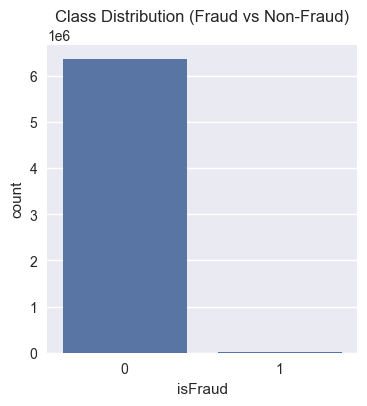

In [13]:
plt.figure(figsize=(4,4))
sns.countplot(x="isFraud", data=df)
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.show()

- 전체 거래 중 사기 거래의 비율은 극히 낮아 심각한 클래스 불균형이 존재


- 이로 인해 단순 Accuracy 지표는 모델 성능을 왜곡할 수 있으며, Precision–Recall 기반의 평가 지표가 더 적합


#### 💳 6. 거래 유형(type) 분포

In [14]:
df["type"].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [15]:
pd.crosstab(df["type"], df["isFraud"])

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


- 거래 유형별 사기 발생 여부를 확인한 결과, 사기 거래(isFraud = 1)는 TRANSFER와 CASH_OUT 유형에서만 발생


- 이는 PaySim 데이터 설명에서 제시된 사기 시나리오 (자금 이체 후 현금 인출)와 일관된 패턴!

- 따라서 이후 분석 및 모델링 과정에서는 TRANSFER, CASH_OUT 거래에 집중

#### 🚩 7. isFlaggedFraud 기초 통계

=>  EDA 단계까지만 — 깊은 분석은 02번 노트북!

In [16]:
df["isFlaggedFraud"].value_counts()


isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [17]:
pd.crosstab(df["isFlaggedFraud"], df["isFraud"])

isFraud,0,1
isFlaggedFraud,,
0,6354407,8197
1,0,16


- isFlaggedFraud 값이 1인 경우는 모두 사기 거래에 해당! => 그러나 해당 사례의 수는 전체 데이터 대비 극히 적음(16건)

- 이 변수는 정보량이 매우 제한적이므로, 단독 예측 변수로서의 활용 가치는 낮을 것으로 판단


#### 💰 8. amount 분포 (로그 스케일)

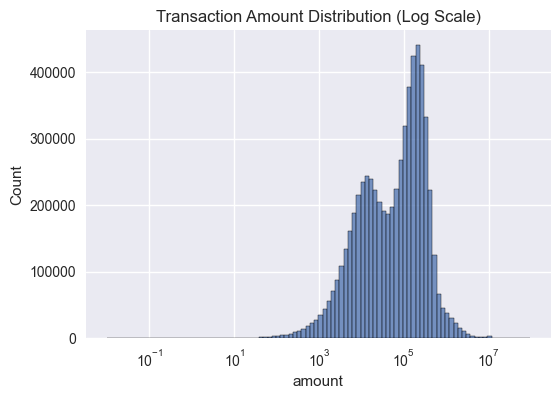

In [18]:
plt.figure(figsize=(6,4))
sns.histplot(df["amount"], bins=100, log_scale=True)
plt.title("Transaction Amount Distribution (Log Scale)")
plt.show()


- 거래 금액(amount)은 극단적으로 오른쪽으로 치우친 분포 -> 이는 소수의 매우 큰 거래 금액이 존재함을 의미

- 이러한 특성은 모델 학습 시 로그 변환 또는 스케일링의 필요성 시사

#### 🧠 9. Summary

- 명시적인 NaN 값은 없으나, 0 값이 잠재적 결측치 역할을 할 가능성 존재

- 데이터는 심각한 클래스 불균형을 가짐 → Precision–Recall 기반 접근 필요

- Fraud는 TRANSFER, CASH_OUT 거래에서만 발생

- isFlaggedFraud 변수는 정보량이 극히 낮음

- amount 분포는 심하게 skewed 되어 있어 변환 필요성 존재
